In [2]:
import patchseq_utils.analysis as utils
from patchseq_utils import plotting as plot
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os.path
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# fix slow autocomplete
%config Completer.use_jedi = False

pd.set_option('use_inf_as_na', True)
pd.options.display.max_columns=300
pd.options.display.max_rows=300
sns.set(style='ticks', context='talk')
from importlib import reload

params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

/local1/storage/envs/ipfx38/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/l1_load.py:131: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  human_df['primary_ephys'] = human_df.eval('collaborator=="AIBS" & failed_fx_long_squares==False')


In [3]:
from patchseq_utils import l1_load
from patchseq_utils import util
from importlib import reload
reload(l1_load)
reload(util)

/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/l1_load.py:131: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  human_df['primary_ephys'] = human_df.eval('collaborator=="AIBS" & failed_fx_long_squares==False')


<module 'patchseq_utils.util' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/util.py'>

In [4]:
from patchseq_utils.l1_load import *
from patchseq_utils.util import *

(0.0, 400.0)

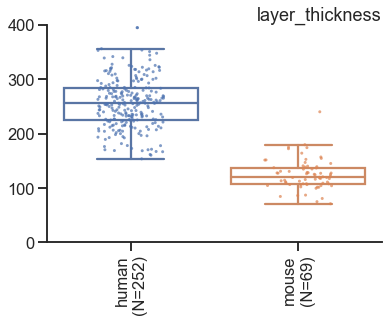

In [6]:
combined_all = pd.concat([human_df, mouse_df], sort=False)
data = combined_all.query("layer=='1'")
y = "layer_thickness"
x = "species"
utils.plot_box_cluster_feature(data, y, x)
plt.ylim(0, 400)

In [201]:
cyto_df = pd.read_csv("../data/Source data cortical structure L1 all areas.csv")
cyto_df.columns = [x.replace(' um', ' µm') for x in cyto_df.columns]

In [280]:
cyto_df.columns

Index(['ROI nr', 'Species', 'Cortical area', 'Human subject nr/mouse nr',
       'Slice nr', 'L1 thickness, µm', 'L1 Neuron Density',
       'Cell Soma Area, µm', 'Neuron Count in 1 mm wide ROI of L1'],
      dtype='object')

In [202]:
cyto_mouse = cyto_df.query("Species=='mouse'").copy()
cyto_mouse['id'] = '0'+cyto_mouse['Human subject nr/mouse nr'].astype(str)

In [203]:
cyto_mouse['id'] = cyto_mouse['id'].replace(
    {
        '050041451':'0500414519',
        '050041139':'0500411394',
        '050041002':'0500410024',
        '050040950':'0500409501',
        '050040855':'0500408552',
        '050040246':'0500402460',
        '050040356':'0500403564',
    })

ids_str = ', '.join([f"'{sid}'" for sid in cyto_mouse['id'].unique()])

In [242]:
from patchseq_utils.lims import df_from_query

query = f"""
select distinct s.barcode, s.name, sc.resolution, scanners.name as scanner
from slides s
join scans sc on sc.slide_id=s.id
join scanners on sc.scanner_id=scanners.id
where s.barcode in ({ids_str})
"""
lims_df = df_from_query(query).set_index('barcode')
lims_df


,name,resolution,scanner
barcode,,,
0500406979,447414a.1.20,0.9982,APERIO
0500410024,308310.1.41,0.9982,APERIO
0500409501,309-604312.5.1,0.3200,VERSABRIGHT
0500402460,447414a.1.52,0.9887,APERIO
0500408552,308310.1.37,0.4945,APERIO
0500411394,447414a.1.30,0.9982,APERIO
0500414519,309-604312.1.1,0.3200,VERSABRIGHT
0500403564,447414a.1.49,0.9887,APERIO


In [243]:
lims_df.resolution.replace(0.3200, 0.55, inplace=True)
joined = cyto_mouse.join(lims_df, on='id', how='left', rsuffix='_lims')

(0.0, 209.4745673715)

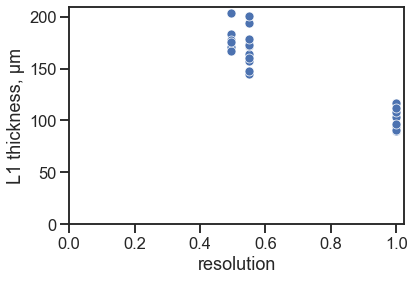

In [244]:
y = 'L1 thickness, µm'
data=joined[joined['Cortical area']=='Visual Cortex']
sns.scatterplot(data=data, x='resolution', y=y)
plt.xlim(0,None)
plt.ylim(0,None)

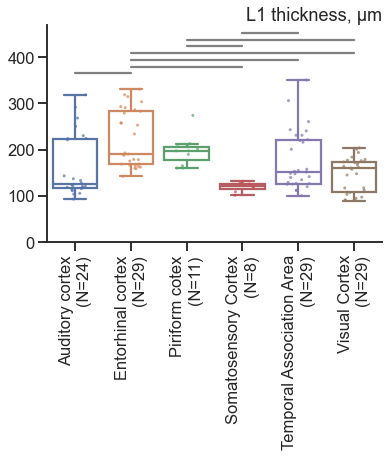

In [245]:
data = joined
y = 'L1 thickness, µm'
x = "Cortical area"
utils.plot_box_cluster_feature(data, y, x)
# plt.ylim(0, 400)

In [246]:
f = joined['resolution']
joined['L1 thickness, µm'] *= f/0.989
joined['Cell Soma Area, µm'] *= (f**2) /0.989 #not squared in original 
joined['L1 Neuron Density'] *= (f**-2) *0.989
joined['Neuron Count in 1 mm wide ROI of L1'] *= f**-1

In [247]:
human_df = cyto_df.query("Species=='human '").copy()
f = 0.989
human_df['L1 thickness, µm'] *= f
human_df['Cell Soma Area, µm'] *= f**2
human_df['L1 Neuron Density'] *= f**-2
human_df['Neuron Count in 1 mm wide ROI of L1'] *= f**-1

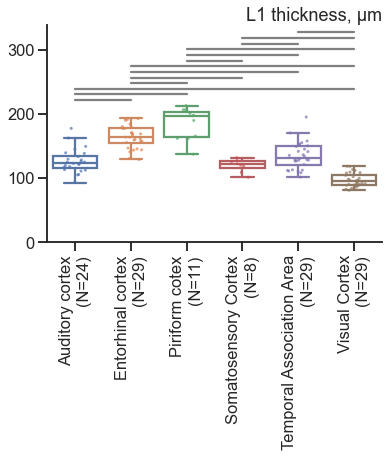

In [248]:
data = joined
utils.plot_box_cluster_feature(data, y, x)

In [270]:
full_df = pd.concat([human_df, joined])
mouse_areas = ['TEa','VISp','AUD','ENT','PIR','SSp']
human_areas = ['FCx','MTG']
full_df['area'] = full_df['Cortical area'].replace(
{
    'Frontal Cortex': 'FCx',
    'Temporal Cortex': 'MTG',
    'Visual Cortex': 'VISp',
    'Temporal Association Area': 'TEa',
    'Somatosensory Cortex': 'SSp',
    'Auditory cortex': 'AUD',
    'Entorhinal cortex': 'ENT',
    'Piriform cotex': 'PIR'
}).astype(pd.CategoricalDtype(human_areas+mouse_areas, ordered=True))

In [250]:
reload(utils)

<module 'patchseq_utils.analysis' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/analysis.py'>

In [278]:
data = full_df[full_df.area.isin(['FCx','MTG','VISp','TEa'])]
data.groupby('area')['L1 thickness, µm',].describe()

L1 thickness, µm                                                 \
                count        mean        std         min         25%   
area                                                                   
FCx              23.0  226.846878  49.541680  156.948129  189.204288   
MTG              76.0  230.104942  65.401869  108.809195  192.429752   
TEa              29.0  134.285356  20.811367  101.171739  120.764037   
VISp             29.0   96.725947  10.590186   80.669906   88.981732   
AUD               0.0         NaN        NaN         NaN         NaN   
ENT               0.0         NaN        NaN         NaN         NaN   
PIR               0.0         NaN        NaN         NaN         NaN   
SSp               0.0         NaN        NaN         NaN         NaN   

                                          
             50%         75%         max  
area                                      
FCx   216.217543  244.987333  349.050948  
MTG   223.306946  253.185998  495.210434  
TEa   130.230341  148.943644  194.830107  
VISp   95.478465  104.012420  118.170924  
AUD          NaN         NaN         NaN  
ENT          NaN         NaN         NaN  
PIR          NaN         NaN         NaN  
SSp          NaN         NaN         NaN

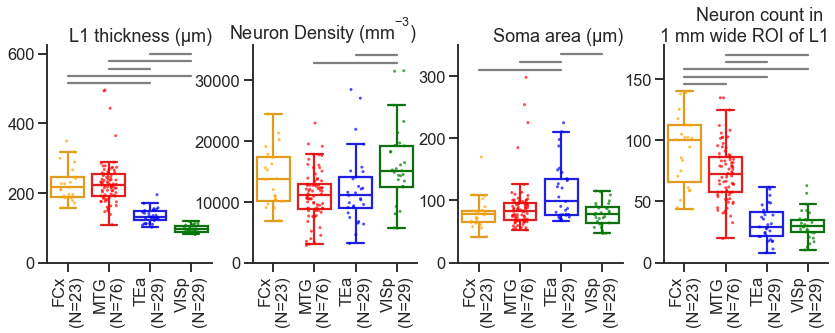

In [293]:
data = full_df[full_df.area.isin(['FCx','MTG','VISp','TEa'])]
x = "area"
features = [
'L1 thickness, µm',
'L1 Neuron Density',
'Cell Soma Area, µm',
'Neuron Count in 1 mm wide ROI of L1',
]
labels = [
'L1 thickness (µm)',
'Neuron Density ($mm^{-3}$)',
'Soma area (µm)',
'Neuron count in \n1 mm wide ROI of L1',
]
palette = {
    'FCx':'orange',
    'MTG':'red',
    'VISp':'green',
    'TEa':'blue'
}
utils.plot_boxplot_multiple(data=data, features=features, labels=labels, x=x, 
                            horizontal=True, figsize=(14,4), palette=palette)
save_plot_multiple(figdir/'f3_cytoarchitecture', ['svg'])

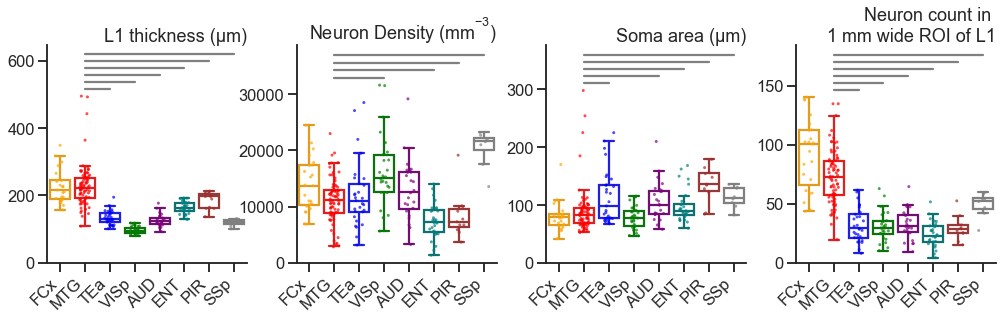

In [292]:
data = full_df
x = "area"
features = [
'L1 thickness, µm',
'L1 Neuron Density',
'Cell Soma Area, µm',
'Neuron Count in 1 mm wide ROI of L1',
]
labels = [
'L1 thickness (µm)',
'Neuron Density ($mm^{-3}$)',
'Soma area (µm)',
'Neuron count in \n1 mm wide ROI of L1',
]
pairs=[('MTG',x) for x in mouse_areas]
palette = {
    'FCx':'orange',
    'MTG':'red',
    'VISp':'green',
    'TEa':'blue',
    'AUD':'purple',
    'ENT':'teal',
    'PIR':'brown',
    'SSp':'grey'
}
utils.plot_boxplot_multiple(data=data, features=features, labels=labels, x=x, horizontal=True, 
                        label_counts=False, pairs=pairs, palette=palette, figsize=(17,4))
save_plot_multiple(figdir/'s6_cytoarchitecture', ['svg'])

(0.0, 120.04597504967846)

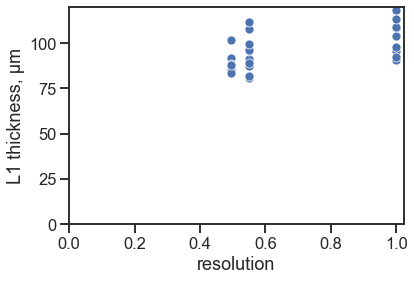

In [254]:
temp = data.query("area=='VIS'").copy()

sns.scatterplot(data=temp, x='resolution', y=y)
plt.xlim(0,None)
plt.ylim(0,None)

In [256]:
temp.groupby('resolution')[y].mean()

resolution
0.4945     89.861092
0.5500     93.931745
0.9982    103.518633
Name: L1 thickness, µm, dtype: float64